[ 임소영 ] 의사결정트리, 부스팅

[ 피쳐-(임시) ] 단백질(g),나트륨(mg) ,당류(g), 포화지방(g)

[ 데이터셋 ] 
- 맥도날드 : https://www.kaggle.com/datasets/mcdonalds/nutrition-facts
- 롯데리아 : https://www.lotteeatz.com/upload/stg/etc/ria/items.html
- 미국 전 지점 : https://www.kaggle.com/datasets/ulrikthygepedersen/fastfood-nutrition
- 버거킹 : https://emilysinglelife.tistory.com/62
- 맘스터치(이미지) : https://www.momstouch.co.kr/m/brand/notice-view.php?idx=49
- 노브랜드 : https://realjace.tistory.com/entry/%EB%85%B8%EB%B8%8C%EB%9E%9C%EB%93%9C%EB%B2%84%EA%B1%B0-%EB%A9%94%EB%89%B4%EB%B3%84-%EC%B9%BC%EB%A1%9C%EB%A6%AC-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84-%EC%B4%9D%EC%A0%95%EB%A6%AC
- 프랭크 버거 : https://rooftoper.tistory.com/entry/%ED%94%84%EB%9E%AD%ED%81%AC-%EB%B2%84%EA%B1%B0-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84

## 자료 준비, 전처리 (결측치, 중복값, 이상치)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
file = './Hamburger.csv'
data = pd.read_csv(file)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1066 non-null   object 
 1   item        1066 non-null   object 
 2   calories    1066 non-null   float64
 3   sodium      1066 non-null   float64
 4   sugar       1066 non-null   float64
 5   total_fat   1066 non-null   float64
 6   protein     1066 non-null   float64
dtypes: float64(5), object(2)
memory usage: 58.4+ KB


In [8]:
data.isna().sum()

restaurant    0
item          0
calories      0
sodium        0
sugar         0
total_fat     0
protein       0
dtype: int64

In [9]:
data.duplicated().sum()

0

In [10]:
data

,restaurant,item,calories,sodium,sugar,total_fat,protein
0,McDonalds,Artisan Grilled Chicken Sandwich,380.00,1110.00,11.00,7.00,37.00
1,McDonalds,Single Bacon Smokehouse Burger,840.00,1580.00,18.00,45.00,46.00
2,McDonalds,Double Bacon Smokehouse Burger,1130.00,1920.00,18.00,67.00,70.00
3,McDonalds,Grilled Bacon Smokehouse Chicken Sandwich,750.00,1940.00,18.00,31.00,55.00
4,McDonalds,Crispy Bacon Smokehouse Chicken Sandwich,920.00,1980.00,18.00,45.00,46.00
...,...,...,...,...,...,...,...
1061,prank_burger,ëë¸ì¹ì¦ë²ê±°(L),687.04,4.55,33.45,19.51,1149.60
1062,prank_burger,ë¨¸ì¬ë£¸ë²ê±°(L),665.30,13.58,26.75,18.10,1203.43
1063,prank_burger,JGë²ê±°(L),828.28,6.42,48.23,22.28,1574.77
1064,prank_burger,SGë¶ê³ ê¸°ë²ê±°(L),491.06,13.84,17.24,10.60,606.15


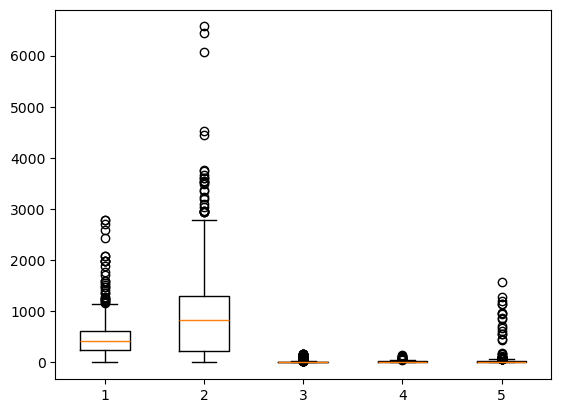

In [11]:
plt.boxplot(data[['calories','sodium','sugar','total_fat','protein']])
plt.show()

In [12]:
def print_flier(insert_data):
    q1 = insert_data.quantile(0.25)
    q3 = insert_data.quantile(0.75)
    iqr = q3 - q1
    #print(f"[ q1 ] \n{q1}\n\n[ q3 ] \n{q3}\n")
    #print(f"[ iqr의 범위 ]\n{iqr}\n")

    print('------------------ 이상값이 될 기준 계산 ------------------\n')

    lower = q1 - 1.5 * iqr
    #print(f"[ lower의 값 ]\n{lower}\n")
    upper = q3 + 1.5 * iqr
    #print(f"[ upper의 값 ]\n{upper}\n")

    mask = insert_data < lower
    print(f"[ lower의 개수 ]\n{mask.sum()}\n")
    mask2 = insert_data > upper
    print(f"[ upper의 개수 ]\n{mask2.sum()}\n")

    return lower, upper

lower, upper = print_flier(data[['calories','sodium','sugar','total_fat','protein']])

------------------ 이상값이 될 기준 계산 ------------------

[ lower의 개수 ]
calories     0
sodium       0
sugar        0
total_fat    0
protein      0
dtype: int64

[ upper의 개수 ]
calories      31
sodium        26
sugar        150
total_fat     33
protein       45
dtype: int64



In [13]:
data[['calories','sodium','sugar','total_fat','protein']].shape

(1066, 5)

In [14]:
def drop_flier(insert_data, col_name):
    global lower
    global upper
    print(f"이상치 제거 전 shape 확인: {insert_data.shape}")
    mask = insert_data[col_name] >= lower.loc[col_name]
    insert_data = insert_data[mask]
    #print(f" '{col_name}' 컬럼에서 lower 미만의 값 제거 후 shape: {insert_data.shape}")

    mask2 = insert_data[col_name] <= upper.loc[col_name]
    insert_data = insert_data[mask2]
    #print(f" '{col_name}' 컬럼에서 upper 초과의 값 제거 후 shape: {insert_data.shape}\n")
    
    print(f"이상치 제거 후 shape 확인: {insert_data.shape} \n")
    return insert_data

data_for_drop = data[['calories','sodium','sugar','total_fat','protein']]
data_for_drop = drop_flier(data_for_drop, 'calories')
data_for_drop = drop_flier(data_for_drop, 'sodium')
data_for_drop = drop_flier(data_for_drop, 'sugar')
data_for_drop = drop_flier(data_for_drop, 'total_fat')
data_for_drop = drop_flier(data_for_drop, 'protein')

data_for_drop.shape

이상치 제거 전 shape 확인: (1066, 5)
이상치 제거 후 shape 확인: (1035, 5) 

이상치 제거 전 shape 확인: (1035, 5)
이상치 제거 후 shape 확인: (1025, 5) 

이상치 제거 전 shape 확인: (1025, 5)
이상치 제거 후 shape 확인: (884, 5) 

이상치 제거 전 shape 확인: (884, 5)
이상치 제거 후 shape 확인: (866, 5) 

이상치 제거 전 shape 확인: (866, 5)
이상치 제거 후 shape 확인: (849, 5) 



(849, 5)

In [15]:
len(list(data_for_drop.index))

849

In [16]:
len(list(data.index))

1066

In [17]:
# 이상치 제거한 데이터에 맞게 원본 데이터도 제거된 인덱스 번호를 같이 drop 시켜줌
for i in list(data.index):
    if i not in (list(data_for_drop.index)):
        data.drop(i,inplace = True)
print(data.shape)

(849, 7)


In [18]:
# 인덱스 번호가 서로 일치하는지 확인
print(len(list(data_for_drop.index)) == len(list(data.index)))
# 서로 일치하는 것을 확인 했으니 이 데이터를 이용해서 알고리즘 돌리겠다.

True


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 849 entries, 0 to 1048
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  849 non-null    object 
 1   item        849 non-null    object 
 2   calories    849 non-null    float64
 3   sodium      849 non-null    float64
 4   sugar       849 non-null    float64
 5   total_fat   849 non-null    float64
 6   protein     849 non-null    float64
dtypes: float64(5), object(2)
memory usage: 53.1+ KB


In [20]:
data.corr(numeric_only=True)
#??뭐지?? 왜 나트륨이 가장 상관관계가 높지? 나트륨은 칼로리가 없는 것으로 확인되는데?

,calories,sodium,sugar,total_fat,protein
calories,1.000000,0.857406,0.280069,0.792358,0.837142
sodium,0.857406,1.000000,0.160776,0.742756,0.827212
sugar,0.280069,0.160776,1.000000,0.099143,0.204728
total_fat,0.792358,0.742756,0.099143,1.000000,0.665800
protein,0.837142,0.827212,0.204728,0.665800,1.000000


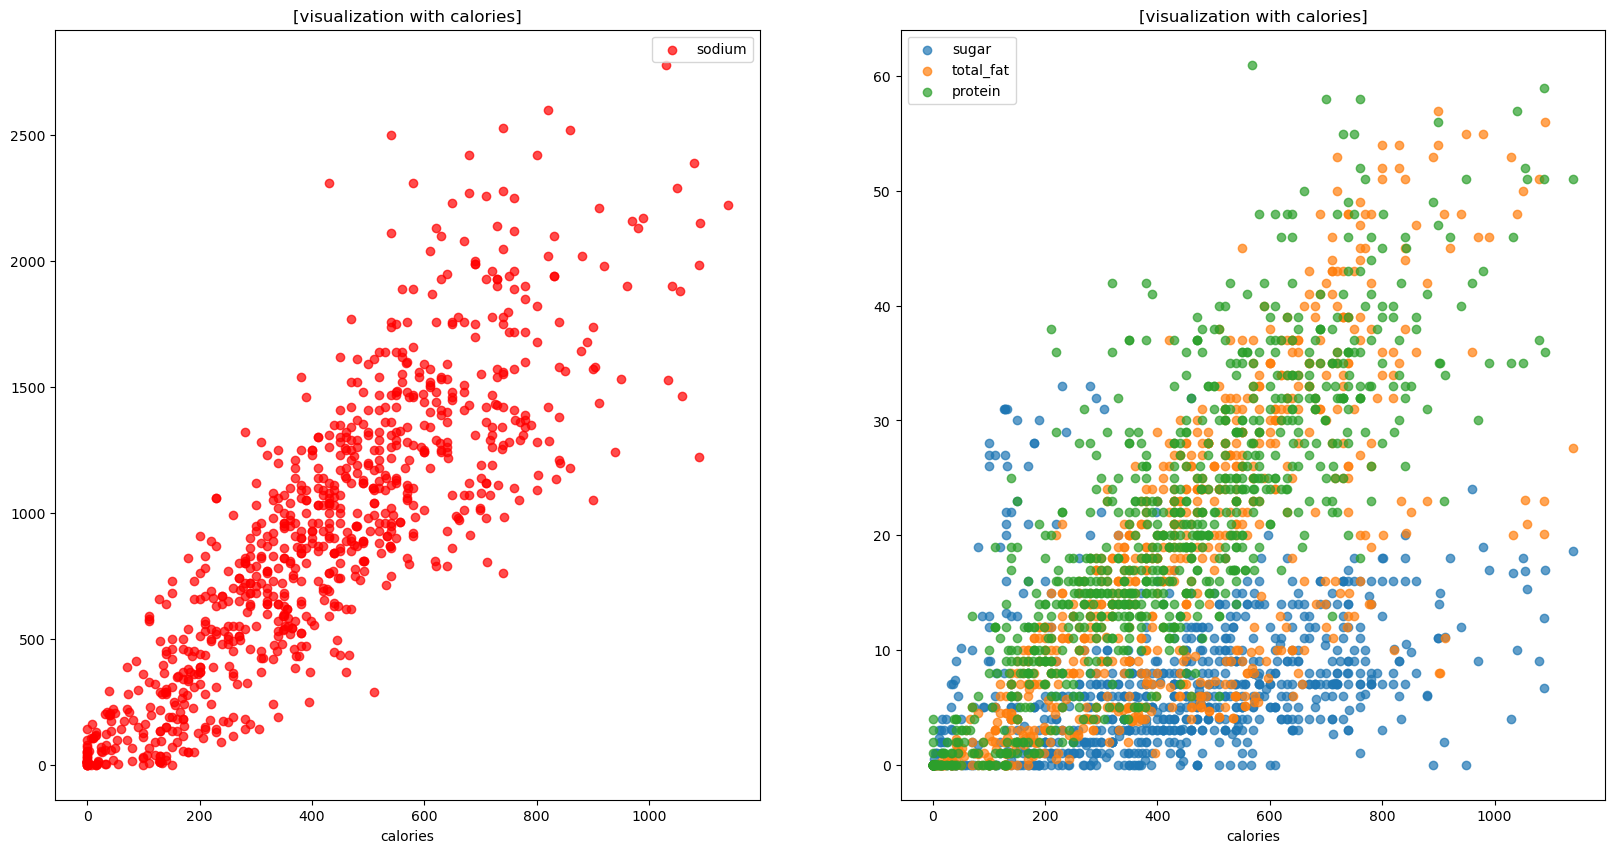

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(data['calories'], data['sodium'], label = 'sodium', c = 'red', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")

plt.subplot(1,2,2)
plt.scatter(data['calories'], data['sugar'], label = 'sugar', alpha = 0.7)
plt.scatter(data['calories'], data['total_fat'], label = 'total_fat', alpha = 0.7)
plt.scatter(data['calories'], data['protein'], label = 'protein', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")
plt.show()

## 데이터셋 분리

In [22]:
target = data['calories']
feature = data[['sodium','sugar','total_fat','protein']]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 7)

print(f"[훈련용] X_train : {X_train.shape}   y_train : {y_train.shape}")
print(f"[테스트용] X_test : {y_test.shape}   y_test : {y_test.shape}")

[훈련용] X_train : (636, 4)   y_train : (636,)
[테스트용] X_test : (213,)   y_test : (213,)


## 스케일링

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [25]:
X_train = pd.DataFrame(scaled_X_train, columns = ['sodium', 'sugar', 'total_fat', 'protein'])
X_test = pd.DataFrame(scaled_X_test, columns = ['sodium', 'sugar', 'total_fat', 'protein'])

In [26]:
# 스케일링이 잘 되었는지 확인해보자
"""
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TRAIN')

plt.subplot(1,2,2)
plt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TEST')

plt.tight_layout
plt.show()
"""

# 스케일링이 잘된 것을 확인했다

"\nplt.figure(figsize=(14,6))\nplt.subplot(1,2,1)\nplt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)\nplt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)\nplt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)\nplt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)\nplt.legend(loc = 'best')\nplt.title('preprocessing with STD scaler - TRAIN')\n\nplt.subplot(1,2,2)\nplt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)\nplt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)\nplt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)\nplt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)\nplt.legend(loc = 'best')\nplt.title('preprocessing with STD scaler - TEST')\n\nplt.tight_layout\nplt.show()\n"

## 학습 및 평가

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
model = DecisionTreeRegressor()

In [29]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [30]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"[train score] {train_score}      [test_score] {test_score}")

# 기본값으로 했더니 역시나 과대 적합이 나왔다.

[train score] 0.9999984754218425      [test_score] 0.7131889218322995


- 튜닝 : GridSearchCV 사용

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
DTR_model = DecisionTreeRegressor()

param = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
         'splitter' : ['best', 'random'],
         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
         'min_samples_leaf': [1,2,3,4,5]
        }   
cv_num = 5

# 모델 생성
gs = GridSearchCV(DTR_model, param_grid = param, cv = cv_num, return_train_score = True)

# 학습 및 평가
result = gs.fit(X_train, y_train)
resultDF = pd.DataFrame(gs.cv_results_)
print(f"max train score : {max(resultDF['mean_train_score'])}")
print(f"max test score : {max(resultDF['mean_test_score'])}\n")

# 최고 성능의 파라미터, 최고의 점수
print(f"best parameters : {gs.best_params_}")
print(f"best score : {gs.best_score_}")

max train score : 0.9823416650990173
max test score : 0.8312129118856735

best parameters : {'criterion': 'poisson', 'max_depth': 6, 'min_samples_leaf': 4, 'splitter': 'best'}
best score : 0.8312129118856735


In [33]:
total_model = gs.best_estimator_
total_model

DecisionTreeRegressor(criterion='poisson', max_depth=6, min_samples_leaf=4)

## 예측

In [34]:
y_pred = total_model.predict(X_test)
y_pred

array([6.55000000e+02, 6.18666667e+02, 5.06865854e+02, 7.11773585e+02,
       5.06865854e+02, 7.11773585e+02, 7.77777778e-01, 1.44243243e+02,
       6.20000000e+02, 7.11773585e+02, 5.25000000e+02, 4.02500000e+01,
       4.15000000e+02, 3.16421875e+02, 1.07000000e+02, 4.02500000e+01,
       5.06865854e+02, 6.38125000e+02, 7.11773585e+02, 7.11773585e+02,
       3.37500000e+01, 1.92500000e+02, 5.67000000e+02, 5.25000000e+02,
       1.44243243e+02, 5.06865854e+02, 5.06865854e+02, 3.16421875e+02,
       5.06865854e+02, 3.16421875e+02, 6.23076923e+02, 7.11773585e+02,
       1.44243243e+02, 6.23076923e+02, 2.78421053e+02, 1.44243243e+02,
       4.29628571e+02, 5.06865854e+02, 3.96800000e+02, 3.16421875e+02,
       4.02500000e+01, 4.29628571e+02, 6.81250000e+02, 3.16421875e+02,
       3.16421875e+02, 4.29628571e+02, 7.11773585e+02, 5.67000000e+02,
       2.78421053e+02, 5.06865854e+02, 2.39545455e+02, 5.06865854e+02,
       3.96800000e+02, 8.74285714e+02, 7.11773585e+02, 7.77777778e-01,
      

## 성능 평가

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
print(f"R2 SCORE : {r2_score(y_test, y_pred)}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

R2 SCORE : 0.8237372040369781
MSE : 10270.870961573606
MAE : 74.06069601716156


## 모델 저장

In [37]:
import joblib
import os

In [38]:
model_dir = './YSY_model/'
model_filename = model_dir + 'decision_tree_03.pkl'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [39]:
joblib.dump(total_model, model_filename)

['./YSY_model/decision_tree_03.pkl']

## decision tree 시각화

In [40]:
# 생성된 모델 구조 시각화
from sklearn.tree import export_graphviz
import graphviz
import pydot

In [41]:
total_model.n_features_in_

4

In [42]:
total_model.max_features_

4

In [43]:
total_model.tree_

In [44]:
dot_data = export_graphviz(total_model,feature_names = total_model.feature_names_in_, rounded = True, filled = True, out_file = "tree.dot")

In [49]:
from graphviz import Source
from graphviz import render
source = Source.from_file("tree.dot", format="png")
source.render("DecisionTree", format="png", cleanup=True)
print("저장됨")

저장됨


In [45]:
pdot = pydot.graph_from_dot_data(dot_data)[0]

TypeError: object of type 'NoneType' has no len()

In [ ]:
pdot.set_graph_defaults(size = '\"15, 15\"')

In [ ]:
graphviz.Source(pdot)

AttributeError: 'Dot' object has no attribute 'splitlines'

In [ ]:
# gz.Source.from_file('./hamburger_tree.dot')